In [ ]:
from random import seed
import matplotlib.pyplot as plt
import benchmark_visualization as bv
import numpy as np
import glob
import os
import json
import re
from statistics import geometric_mean, mean

HOME_DIR = os.environ['HOME']

SHORT_TIMELIMIT = 7200
LONG_TIMELIMIT = 28800

# Default figure save directory (user may override per call)
FIG_SAVE_DIR = os.path.join(HOME_DIR, 'Documents', 'BA_benchmarks')

runs = {}
class BenchmarkRun:
    HEADER = "algorithm,graph,timeout,seed,k,epsilon,num_threads,imbalance,totalPartitionTime,objective,km1,cut,failed"
    
    def __init__(self, content: str, timelimit: int = None):
        self.data = {}
        for i, key in enumerate(self.HEADER.split(',')):
            value = content.split(',')[i].strip()
            # Try to convert to int or float if possible
            try:
                if '.' in value:
                    value = float(value)
                else:
                    value = int(value)
            except ValueError:
                pass
            self.data[key] = value
        self.data['timelimit'] = timelimit

    def get(self, param):
        return self.data[param]

def parse_results_file(file_path: str):
    results_array = []
    timelimit = file_path.split('.')[-2]
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            results_array += [BenchmarkRun(content=line, timelimit=int(timelimit))]
    return results_array

def aggregate_runs(directory_path: str, instances_to_exclude: list = []):
    runs = {}
    for file_path in glob.glob(directory_path + "/*.results"):
        file_name = file_path.split('/')[-1]
        instance_name = '.'.join(file_name.split('.')[:-2])
        purely_instance_name = '.'.join(instance_name.split('.')[:-3])
        if purely_instance_name in instances_to_exclude:
            continue   
        if instance_name not in runs:
            runs[instance_name] = {"short": None, "long": None}

        run_results = parse_results_file(file_path)
        if len(run_results) > 1:
            min_km1=min([run.get('km1') for run in run_results if run.get('failed') == 'no'])
            runs[instance_name]["short"] = min_km1
        elif run_results:
            runs[instance_name]["long"] = run_results[0].get('km1')
        else:
            pass
            #print(f"Warning: No results in file {file_path}")

    return runs


def convert_instance_naming_scheme(instance_name: str, use_fixed_seed: bool) -> str:
    parts = instance_name.split('.')
    hgr_index = parts.index('hgr')
    base_name = '.'.join(parts[:hgr_index + 1])
    
    # Extract parameters from the rest
    k_value = None
    seed_value = None
    timelimit_value = None

    for part in parts[hgr_index + 1:]:
        if part.startswith('k'):
            k_value = part[1:]
        elif part.startswith('seed'):
            seed_value = part[4:]
        elif part.startswith('timelimit'):
            timelimit_value = part[9:]
    
    # Construct new name: base.threads.k.seed.timelimit
    threads = '1'  # Default to 1 thread if not specified
    if use_fixed_seed:
        seed_value = '1'
    new_name = f"{base_name}.{threads}.{k_value}.{seed_value}.{timelimit_value}"
    return new_name


def parse_end_result_history_file(file_path: str):
    # Read the last number from the file
    with open(file_path, 'r') as f:
        lines = f.readlines()
        if lines:
            last_line = lines[-1].strip()
            km1 = int(last_line.split(',')[-1].strip())
        else:
            km1 = None
    return km1

def parse_history_file(file_path: str):
    history = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue         
            if line.startswith('Starttime:'):
                timestamp = int(line.split(':')[1].strip())
                history.append((timestamp, None, None))
            else:
                parts = line.split(',')
                timestamp = int(parts[0].strip())
                mode = parts[1].strip()
                km1_value = int(parts[2].strip())
                history.append((timestamp, mode, km1_value)) 
    return history

def get_average_diff_from_matrix(matrix):
    np_matrix = np.array(matrix)
    mask = ~np.eye(np_matrix.shape[0], dtype=bool)
    off = np_matrix[mask]
    mean = (off.mean() if off.size else 0)
    return mean

def get_average_diff_from_matrices(matrices):
    averages = []
    for matrix in matrices:
        avg = get_average_diff_from_matrix(matrix)
        averages.append(avg)
    return averages

def get_max_diff_from_matrix(matrix):
    np_matrix = np.array(matrix)
    max_val = np_matrix.max()
    return max_val

def get_max_diff_from_matrices(matrices):
    max_values = []
    for matrix in matrices:
        max_val = get_max_diff_from_matrix(matrix)
        max_values.append(max_val)
    return max_values

# --- Figure saving support ---

def _ensure_dir(path: str):
    if path and not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)


def _finalize_figure(fig, show: bool, save: bool, save_dir: str, filename: str, dpi: int):
    if save:
        target_dir = save_dir or FIG_SAVE_DIR
        _ensure_dir(target_dir)
        out_path = os.path.join(target_dir, filename)
        fig.savefig(out_path, dpi=dpi, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)


def plot_combined_data(combined_data, title: str = "Combined History and Difference Matrices", filename: str = None,
                       show: bool = True, save: bool = False, save_dir: str = None, dpi: int = 150):
    """Plot KM1 and diff metrics over time.
    Params:
      combined_data: list of dicts with 'timestamp','km1','diff_matrix'
      filename: optional explicit filename (e.g. 'run1_combined.png')
      show: display inline in notebook
      save: if True, save image
      save_dir: directory to save (defaults to FIG_SAVE_DIR)
      dpi: resolution for saved figure
    """
    timestamps = [entry['timestamp'] for entry in combined_data]
    km1_values = [entry['km1'] for entry in combined_data]
    avg_diffs = [get_average_diff_from_matrix(entry['diff_matrix']) for entry in combined_data]
    max_diffs = [get_max_diff_from_matrix(entry['diff_matrix']) for entry in combined_data]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # First subplot: KM1 values
    color = 'tab:blue'
    ax1.set_xlabel('Time (seconds)', fontsize=12)
    ax1.set_ylabel('KM1 Value', color=color, fontsize=12)
    ax1.plot(timestamps, km1_values, color=color, marker='o', label='KM1 Value')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('KM1 Value over Time', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Second subplot: Average and Max Differences
    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.set_ylabel('Difference Value', fontsize=12)
    ax2.plot(timestamps, avg_diffs, color='tab:red', marker='x', label='Average Difference')
    ax2.plot(timestamps, max_diffs, color='tab:orange', marker='s', label='Max Difference')
    ax2.legend(loc='upper right')
    ax2.set_title('Difference Metrics over Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if filename is None:
        safe = title.lower().replace(' ', '_').replace('/', '_')
        filename = f"{safe}.png"
    _finalize_figure(fig, show, save, save_dir, filename, dpi)


def combine_history_and_diff(history_run, diff_run, time_limit: float = None):
    combined_data = []
    index = 0
    start_time = None
    
    for step in history_run:
        timestamp, mode, km1_value = step
        if mode == None:
            start_time = timestamp
            continue
        if mode == 'Initial':
            # skip
            continue
        
        relative_time = (timestamp - start_time) / 1000.0  
        
        combined_data.append({
            'timestamp': relative_time,
            'mode': mode,
            'km1': km1_value,
            'diff_matrix': diff_run[index]
        })
        index += 1
    ## Append last diff matrix if any left
    if index < len(diff_run):
        combined_data.append({
            'timestamp': time_limit,
            'mode': mode,
            'km1': km1_value,
            'diff_matrix': diff_run[-1]
        })
    
    return combined_data

def aggregate_history_runs(directory_path: str, full_history: bool = False, instances_to_exclude: list = []):
    history_runs = {}
    for file_path in glob.glob(directory_path + "/*.csv"):
        file_name = os.path.basename(file_path)
        thread_id = file_name.split('.')[-3]
        instance_name = '.'.join(file_name.split('.')[:-3]) 
        
        use_fixed_seed = True
        if full_history:
            use_fixed_seed = False
        instance_name = convert_instance_naming_scheme(instance_name, use_fixed_seed)
        
        purely_instance_name = '.'.join(instance_name.split('.')[:-4])
        if purely_instance_name in instances_to_exclude:
            continue
        
        history = parse_history_file(file_path)
        
        # Last entry should be the final result
        km1 = None
        for timestamp, mode, km1_value in reversed(history):
            if mode is not None:
                km1 = km1_value
                break

        # Store only the history for the best run
        if instance_name not in history_runs:
            history_runs[instance_name] = {'thread_id': thread_id, 'km1': km1, 'history': history}
        else:
            if history_runs[instance_name]['km1'] is None:
                pass
            if km1 is not None and km1 < history_runs[instance_name]['km1']:
                history_runs[instance_name] = {'thread_id': thread_id, 'km1': km1, 'history': history}

    return history_runs

def get_diff_matrices_for_best_run(history_runs, diff_matrices_list, instance_name: str):
    if instance_name not in history_runs:
        return None

    best_thread_id = history_runs[instance_name]['thread_id']
    for entry in diff_matrices_list:
        if entry['thread_id'] == best_thread_id:
            return entry['matrices']
    return None


def aggregate_diff_runs(directory_path: str, instances_to_exclude: list = []):
    diff_runs = {}
    for file_path in glob.glob(directory_path + "/*.csv"):
        matrices = bv.parse_diff_matrices(file_path)
        file_name = os.path.basename(file_path)
        thread_id = file_name.split('.')[-3]
        instance_name = '.'.join(file_name.split('.')[:-3])
        use_fixed_seed = True
        instance_name = convert_instance_naming_scheme(instance_name, use_fixed_seed)
        purely_instance_name = '.'.join(instance_name.split('.')[:-4])
        if purely_instance_name in instances_to_exclude:
            continue
        if instance_name not in diff_runs:
            diff_runs[instance_name] = []    
        diff_runs[instance_name].append({
            'thread_id': thread_id,
            'matrices': matrices
        })

    return diff_runs

def split_long_short_history_runs(history_runs):
    long_runs = {}
    short_runs = {}
    for instance_name, run_data in history_runs.items():
        timelimit = int(instance_name.split('.')[-1])
        if timelimit == SHORT_TIMELIMIT:
            short_runs[instance_name] = run_data
        else:
            long_runs[instance_name] = run_data
    return short_runs, long_runs

def split_seed_history_runs(history_runs):
    seed_runs = {}
    for instance_name, run_data in history_runs.items():
        seed = instance_name.split('.')[-2]
        if seed not in seed_runs:
            seed_runs[seed] = {}
        seed_runs[seed][instance_name] = run_data
        
    ## Convert to list
    seed_count = seed_runs.keys().__len__()
    all_seeds_runs = [None] * seed_count
    for seed, runs in seed_runs.items():
        seed_int= int(seed)
        all_seeds_runs[seed_int - 1] = runs
    return all_seeds_runs

def instance_to_seeds(history_runs):
    # Dictionary maps instance_name to its seed runs
    instance_to_seeds = {}
    for instance_name, run_data in history_runs.items():
        purely_instance_name = '.'.join(instance_name.split('.')[:-4])
        seed = int(instance_name.split('.')[-2])
        if purely_instance_name not in instance_to_seeds:
            instance_to_seeds[purely_instance_name] = {}
        instance_to_seeds[purely_instance_name][seed] = run_data
    return instance_to_seeds

def split_k_value_history_runs(history_runs, *k_values):
    k_runs_list = [{} for _ in k_values]
    k_value_to_index = {k: i for i, k in enumerate(k_values)}

    for instance_name, run_data in history_runs.items():
        k_from_instance = instance_name.split('.')[-3]
        
        if k_from_instance in k_value_to_index:
            index = k_value_to_index[k_from_instance]
            k_runs_list[index][instance_name] = run_data
            
    return k_runs_list

def convert_time_for_history_run(history_run):   
    converted_history = []
    start_time = None
    for timestamp, mode, km1_value in history_run:
        if mode is None:
            start_time = timestamp
            # check if already converted first
            if start_time == 0:
                return history_run.copy()
            converted_history.append((0, mode, km1_value))
        else:
            relative_time = (timestamp - start_time) / 1000.0  
            converted_history.append((relative_time, mode, km1_value))
    return converted_history


def make_history_runs_sequential(*history_runs, time_limit=None):
    combined_runs = {}
    padded_history_runs = [None] * len(history_runs)
    # Add time_limit to history run timestamps
    for i, history_run in enumerate(history_runs):
        padded_history_run = {}
        for instance_name, run_data in history_run.items():
            # Fix seed to 1 for combined run
            instance_name_converted = instance_name.rsplit('.', 2)[0] + '.1.' + instance_name.rsplit('.', 1)[1]
            
            # Create a COPY of the history to avoid modifying original
            history = [entry for entry in run_data['history']]  # Copy list
            converted_history = convert_time_for_history_run(history)
            
            # Create new history with offset times
            new_history = []
            for timestamp, mode, km1_value in converted_history:
                new_history.append((timestamp + i * time_limit, mode, km1_value))
            
            padded_history_run[instance_name_converted] = {
                'thread_id': run_data['thread_id'], 
                'km1': run_data['km1'], 
                'history': new_history
            }
        padded_history_runs[i] = padded_history_run
    # Combine all padded history runs
    combined_runs = merge_histories(*padded_history_runs)
    return combined_runs

def merge_histories(*history_runs):
    merged_histories = {}
    for history_run in history_runs:
        for instance_name, run_data in history_run.items():
            if instance_name not in merged_histories:
                # Deep copy the run_data
                merged_histories[instance_name] = {
                    'thread_id': run_data['thread_id'],
                    'km1': run_data['km1'],
                    'history': [entry for entry in run_data['history']]  # Copy history
                }
            else:
                existing_history = merged_histories[instance_name]['history']
                new_history = run_data['history']
                # Append new history entries (creates new list)
                merged_histories[instance_name]['history'] = existing_history + [entry for entry in new_history]
                # Update km1 and thread_id if new run is better
                if run_data['km1'] < merged_histories[instance_name]['km1']:
                    merged_histories[instance_name]['km1'] = run_data['km1']
                    merged_histories[instance_name]['thread_id'] = run_data['thread_id']
                
    # Sort histories by timestamp
    for instance_name, run_data in merged_histories.items():
        run_data['history'].sort(key=lambda x: x[0])
    # History for each instance shall only contain decreasing km1 values
    for instance_name, run_data in merged_histories.items():
        filtered_history = []
        last_km1 = float('inf')
        for entry in run_data['history']:
            time, mode, km1_value = entry
            if km1_value is not None and km1_value < last_km1:
                filtered_history.append(entry)
                last_km1 = km1_value
            elif time == 0:
                filtered_history.append((0, None, None))
        run_data['history'] = filtered_history
    return merged_histories
               
def split_runs_k_value(runs, *k_values):
# Create a list of empty dictionaries, one for each k-value
    k_runs_list = [{} for _ in k_values]
    
    # Create a mapping from k_value to its index for quick lookups
    k_value_to_index = {k: i for i, k in enumerate(k_values)}

    for instance_name, run_data in runs.items():
        k_from_instance = instance_name.split('.')[-2]
        
        if k_from_instance in k_value_to_index:
            index = k_value_to_index[k_from_instance]
            k_runs_list[index][instance_name] = run_data
                
    return k_runs_list

def extract_info_from_config(config_name: str):
    
    result_dict = {}

    # Remove leading date + underscore if present
    base = re.sub(r'^\d{4}-\d{1,2}-\d{1,2}_', '', config_name)

    # Split different parameters on '-'
    # Filter out empty strings (in case of accidental double '-')
    param_groups = [g for g in base.split('-') if g]

    for group in param_groups:
        parts = group.split('_')
        if not parts or parts[0] == '':
            continue
        param_name = parts[0]
        values = parts[1:] if len(parts) > 1 else []
        # Only store if we have at least one value; keep empty list otherwise
        result_dict[param_name] = values

    return result_dict

def create_mean_over_seeds_single_instance(seeds_to_run, instance_name: str):  
    result_list = []
    current_indices = [0] * len(seeds_to_run)
    current_values = [None] * len(seeds_to_run)
    current_times = [0] * len(seeds_to_run)
    max_time = 0
    
    converted_runs = []
    for seed_run in seeds_to_run.values():
        converted_history = convert_time_for_history_run(seed_run['history'])
        converted_runs.append(converted_history)
    
    # First value is special case
    for i, history in enumerate(converted_runs):
        time, mode, km1_value = history[1]
        current_values[i] = km1_value
        current_indices[i] = 1
        current_times[i] = time
        if time > max_time:
            max_time = time
    # update other instances to match max_time
    for i in range(len(current_times)):
        while current_times[i] < max_time:
            index = current_indices[i]
            history = converted_runs[i]
            if index + 1 < len(history) and history[index + 1][0] <= max_time:
                time, mode, km1_value = history[index + 1]
                current_indices[i] += 1
                current_values[i] = km1_value
                current_times[i] = time
            else:
                break
    result_list.append((max_time, mean(current_values)))
    
    end = False
    while not end:
        next_time = float('inf')
        for i, history in enumerate(converted_runs):
            index = current_indices[i]
            if index + 1 < len(history):
                time, mode, km1_value = history[index + 1]
                if time < next_time:
                    next_time = time
                    instance_to_increment = i
                    km1_to_update = km1_value
        ## next time found
        if next_time == float('inf'):
            end = True
            continue
        # Increment the current index for the instance with the next time
        current_indices[instance_to_increment] += 1
        current_values[instance_to_increment] = km1_to_update
        current_times[instance_to_increment] = next_time
        
        # append result list
        result_list.append((next_time, mean(current_values)))
    return result_list
        
        
def max_iterations_per_instance(iteration_runs, multiple_seeds: bool = False):
    # Return the maximum iterations per instance (avg betwen multiple seeds) as a dict
    max_iterations = {}
    if multiple_seeds:
        instance_to_seeds_dict = instance_to_seeds(iteration_runs)
        for instance_name, seed_runs in instance_to_seeds_dict.items():
            max_iters_per_seed = {}
            for seed_run in seed_runs.values():
                timestamp_to_iteration, iteration_to_metric_value = seed_run
                # Get the last iteration
                last_iteration = iteration_to_metric_value[-1][0]
                if instance_name not in max_iters_per_seed:
                    max_iters_per_seed[instance_name] = []
                max_iters_per_seed[instance_name].append(last_iteration)
            max_iterations[instance_name] = mean(max_iters_per_seed[instance_name])
    else:
        for instance_name, run_data in iteration_runs.items():
            timestamp_to_iteration, iteration_to_metric_value = run_data
            last_iteration = iteration_to_metric_value[-1][0]
            max_iterations[instance_name] = last_iteration
    
    return max_iterations
    
def get_iteration_multipliers(baseline_max_iterations, other_max_iterations):
    multipliers = {}
    for instance_name in baseline_max_iterations:
        if instance_name in other_max_iterations:
            baseline_iters = baseline_max_iterations[instance_name]
            other_iters = other_max_iterations[instance_name]
            if baseline_iters > 0:
                multiplier = other_iters / baseline_iters
                multipliers[instance_name] = multiplier
    if multipliers:
        return multipliers
    else:
        return None
    
def create_multiplier_based_history_runs(history_runs, multipliers):
    adjusted_history_runs = {}
    for instance_name, run_data in history_runs.items():
        # Get first timestamp
        last_initial_timestamp = run_data['history'][0][0] if run_data['history'] else 0
        purely_instance_name = '.'.join(instance_name.split('.')[:-4])
        if purely_instance_name in multipliers:
            multiplier = multipliers[purely_instance_name]
            adjusted_history = []
            for timestamp, mode, km1_value in run_data['history']:
                time_diff = timestamp - last_initial_timestamp
                if mode is not None and mode != 'Initial':
                    # Round to nearest integer
                    adjusted_time = last_initial_timestamp + round(time_diff * multiplier)
                else:
                    last_initial_timestamp = timestamp
                    adjusted_time = timestamp
                adjusted_history.append((adjusted_time, mode, km1_value))
            adjusted_history_runs[instance_name] = {
                'thread_id': run_data['thread_id'],
                'km1': run_data['km1'],
                'history': adjusted_history
            }
        else:
            # No adjustment if no multiplier found
            adjusted_history_runs[instance_name] = run_data
    return adjusted_history_runs
           
                    
def create_geomean_over_all_instances(history_runs, multiple_seeds: bool = False):
    result_list = []
    current_indices = {}
    current_values = {}
    current_times = {}
    max_time = 0
    
    if multiple_seeds:
        instance_to_seeds_dict = instance_to_seeds(history_runs)
        # For each instance, compute mean over seeds
        averaged_history_runs = {}
        for instance_name, seed_runs in instance_to_seeds_dict.items():
            mean_history = create_mean_over_seeds_single_instance(seed_runs, instance_name)
            # history list of tuples (time, mode, km1)
            history = [(time, None, km1) for time, km1 in mean_history]
            averaged_history_runs[instance_name] = history
        converted_runs = averaged_history_runs
    
    # Skip conversion if already done for multiple seeds
    if not multiple_seeds:
        converted_runs = {}
        for instance_name, run_data in history_runs.items():
            converted_history = convert_time_for_history_run(run_data['history'])
            converted_runs[instance_name] = converted_history
            
        
    # First value is special case
    for i, (instance_name, history) in enumerate(converted_runs.items()):
        time, mode, km1_value = history[0]
        current_values[instance_name] = km1_value
        current_indices[instance_name] = 1
        current_times[instance_name] = time
        if time > max_time:
            max_time = time
    
    # update other instances to match max_time
    for instance_name in current_times:
        while current_times[instance_name] < max_time:
            index = current_indices[instance_name]
            history = converted_runs[instance_name]
            if index + 1 < len(history) and history[index + 1][0] <= max_time:
                time, mode, km1_value = history[index + 1]
                current_indices[instance_name] += 1
                current_values[instance_name] = km1_value
                current_times[instance_name] = time
            else:
                break
    # Check for 0 values in current_results and substitute with 1
    for instance_name in current_values:
        if current_values[instance_name] == 0:
            current_values[instance_name] = 1 
    result_list.append((max_time, geometric_mean(current_values.values())))
    
    end = False
    while not end:
        next_time = float('inf')
        for i, (instance_name, history) in enumerate(converted_runs.items()):
            index = current_indices[instance_name]
            if index + 1 < len(history):
                time, mode, km1_value = history[index + 1]
                if time < next_time:
                    next_time = time
                    instance_to_increment = instance_name
                    km1_to_update = km1_value
        ## next time found
        if next_time == float('inf'):
            end = True
            continue
        # Increment the current index for the instance with the next time
        current_indices[instance_to_increment] += 1
        current_values[instance_to_increment] = km1_to_update
        current_times[instance_to_increment] = next_time
        
        # append result list
        result_list.append((next_time, geometric_mean(current_values.values())))

    return result_list

def eval_k_kway(
    configs_name="",
    all_configs_root=os.path.expanduser("~/Documents/experiment_results"),
    results_dirname="mt_kahypar_evo_results",
    diff_dirname="evo_diff",
    history_dirname="evo_history",
    instances_to_exclude=None,
    show_full_history=False,
    default_pop_size=10,
):

    all_configs_dir = os.path.join(all_configs_root, configs_name)

    # Loop through each folder inside DIR
    all_geomeans = {}

    for config_dir in glob.glob(all_configs_dir + "/*/"):
        config_name = os.path.basename(os.path.normpath(config_dir))
        print(f"Processing configuration: {config_name}")

        config_info = extract_info_from_config(config_name)

        k_values = config_info.get('k', None)
        kway_value = config_info.get('kway', None)
        if kway_value:
            kway_value = kway_value[0]
        pop_size = config_info.get('pop', None)

        result_dir = os.path.join(config_dir, results_dirname)
        diff_dir = os.path.join(config_dir, diff_dirname)
        history_dir = os.path.join(config_dir, history_dirname)

        # Aggregate runs from result files
        runs = aggregate_runs(result_dir, instances_to_exclude=instances_to_exclude)
        k_runs = split_runs_k_value(runs, *k_values) if k_values else [runs]
        k_runs_dict = {}
        if k_values:
            for i, k in enumerate(k_values):
                k_runs_dict[k] = k_runs[i]

        history_runs = aggregate_history_runs(history_dir, full_history=show_full_history, instances_to_exclude=instances_to_exclude)
        #diff_runs = aggregate_diff_runs(diff_dir, instances_to_exclude=instances_to_exclude)  # kept for completeness
        k_history_runs = split_k_value_history_runs(history_runs, *k_values) if k_values else [history_runs]
        k_history_runs_dict = {}
        if k_values:
            for i, k in enumerate(k_values):
                k_history_runs_dict[k] = k_history_runs[i]

        # Create Geomeans for each configuration
        for k in k_values:
            k_run = k_runs_dict[k]
            k_history_run = k_history_runs_dict[k]
            if k == '64' and kway_value == '2':
                pass
            geomean = create_geomean_over_all_instances(k_history_run, multiple_seeds=show_full_history)
            config = (k, kway_value, pop_size[0] if pop_size else default_pop_size)
            all_geomeans[config] = geomean

    # Plot all kway geomeans for each k-value in separate plots (data prep only)
    k_pop_to_kway_geomeans = {}
    for (k, kway, pop_size), geomean in all_geomeans.items():
        key = (k, pop_size)
        if key not in k_pop_to_kway_geomeans:
            k_pop_to_kway_geomeans[key] = {}
        k_pop_to_kway_geomeans[key][kway] = geomean

    # Directory where plots will be saved by the final loop
    save_path = os.path.join(FIG_SAVE_DIR, configs_name)
    return k_pop_to_kway_geomeans, save_path

def eval_evothreads(
    configs_name="",
    all_configs_root=os.path.expanduser("~/Documents/experiment_results"),
    results_dirname="mt_kahypar_evo_results",
    diff_dirname="evo_diff",
    history_dirname="evo_history",
    instances_to_exclude=None,
    show_full_history=False
):
    all_configs_dir = os.path.join(all_configs_root, configs_name)
    # Loop through each folder inside DIR
    thread_count = 1
    all_geomeans = {}
    for config_dir in glob.glob(all_configs_dir + "/*/"):
        config_name = os.path.basename(os.path.normpath(config_dir))
        print(f"Processing configuration: {config_name}")
        
        config_info = extract_info_from_config(config_name)
        threads_per_worker = config_info.get('parallel', None)
        
        result_dir = os.path.join(config_dir, results_dirname)
        diff_dir = os.path.join(config_dir, diff_dirname)
        history_dir = os.path.join(config_dir, history_dirname)
        
        # Aggregate runs from result files
        runs = aggregate_runs(result_dir, instances_to_exclude=instances_to_exclude)
        history_runs = aggregate_history_runs(history_dir, full_history=show_full_history, instances_to_exclude=instances_to_exclude)

        if not show_full_history:
            geomean = create_geomean_over_all_instances(history_runs)
        else:
            geomean = create_geomean_over_all_instances(history_runs, multiple_seeds=True)
        threads_per_worker = int(threads_per_worker[0]) if threads_per_worker else "default"
        thread_count = max(thread_count, threads_per_worker)
        all_geomeans[threads_per_worker] = geomean
        
    # Directory where plots will be saved by the final loop
    save_path = os.path.join(FIG_SAVE_DIR, configs_name)
    return all_geomeans, save_path, thread_count
    
    
def eval_generic_by_name(
    configs_name="",
    all_configs_root=os.path.expanduser("~/Documents/experiment_results"),
    results_dirname="mt_kahypar_evo_results",
    diff_dirname="evo_diff",
    history_dirname="evo_history",
    instances_to_exclude=None,
    show_full_history=False,
    plot_iterations=False
): 
    all_configs_dir = os.path.join(all_configs_root, configs_name)
    # Loop through each folder inside DIR
    all_geomeans = {}
    for config_dir in glob.glob(all_configs_dir + "/*/"):
        config_name = os.path.basename(os.path.normpath(config_dir))
        print(f"Processing configuration: {config_name}")
        
        result_dir = os.path.join(config_dir, results_dirname)
        diff_dir = os.path.join(config_dir, diff_dirname)
        history_dir = os.path.join(config_dir, history_dirname)
        
        # Aggregate runs from result files
        runs = aggregate_runs(result_dir, instances_to_exclude=instances_to_exclude)
        history_runs = aggregate_history_runs(history_dir, full_history=show_full_history, instances_to_exclude=instances_to_exclude)

        if not show_full_history:
            geomean = create_geomean_over_all_instances(history_runs)
        else:
            geomean = create_geomean_over_all_instances(history_runs, multiple_seeds=True)
        
        # Remove date prefix if present    
        config_name_cleaned = remove_date_prefix(config_name)
        all_geomeans[config_name_cleaned] = geomean
        
    # Directory where plots will be saved by the final loop
    save_path = os.path.join(FIG_SAVE_DIR, configs_name)
    return all_geomeans, save_path
    
    
def remove_date_prefix(name: str) -> str:
    return re.sub(r'^\d{4}-\d{1,2}-\d{1,2}_', '', name)
    
def aggregate_iterations_runs(directory_path: str, show_full_history: bool = False, instances_to_exclude: list = []):
    iteration_runs = {}
    for file_path in glob.glob(directory_path + "/*.csv"):
        file_name = os.path.basename(file_path)
        instance_name = '.'.join(file_name.split('.')[:-3]) 
        
        use_fixed_seed = True
        if show_full_history:
            use_fixed_seed = False
        instance_name = convert_instance_naming_scheme(instance_name, use_fixed_seed)
        
        purely_instance_name = '.'.join(instance_name.split('.')[:-4])
        if purely_instance_name in instances_to_exclude:
            continue
        
        timestamp_to_iteration, iteration_to_metric_value = get_iteration_run(file_path)
        iteration_runs[instance_name] = (timestamp_to_iteration, iteration_to_metric_value)
    return iteration_runs

def get_iteration_run(iteration_run_file: str):
    ## Return two lists: timestamp_to_iteration and iteration_to_metric_value
    timestamp_to_iteration = []
    iteration_to_metric_value = []
    # iteration log file format: iteration, timestamp, metric_value
    with open(iteration_run_file, 'r') as f:
        first_timestamp = None
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 3:
                try:
                    iteration = int(parts[0].strip())
                    timestamp = int(parts[1].strip())
                    metric_value = float(parts[2].strip())
                    
                    if first_timestamp is None:
                        first_timestamp = timestamp
                        
                    normalized_timestamp = (timestamp - first_timestamp) / 1000.0  # in seconds
                    
                    timestamp_to_iteration.append((normalized_timestamp, iteration))
                    iteration_to_metric_value.append((iteration, metric_value))
                except ValueError:
                    continue
    return timestamp_to_iteration, iteration_to_metric_value

def plot_iteration_data(*datasets, title: str = "", labels=None, filename: str = None,
                     show: bool = True, save: bool = False, save_dir: str = None, dpi: int = 150, iteration_to_metric: bool = False,
                     timestamp_to_iteration: bool = False):
    
    assert (iteration_to_metric != timestamp_to_iteration), "Only one of iteration_to_metric or timestamp_to_iteration can be True."
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['b', 'r', 'g', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(datasets))]  
    for i, data in enumerate(datasets):
        x = [entry[0] for entry in data]
        y = [entry[1] for entry in data]
        
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        label = labels[i] if i < len(labels) else f'Dataset {i+1}'
        
        ax.plot(x, y, marker=marker, color=color, label=label, markersize=3)
        
    ax.set_title(title, fontsize=14, fontweight='bold')
    if iteration_to_metric:
        ax.set_xlabel('Iteration', fontsize=12)
        ax.set_ylabel('Metric Value', fontsize=12)
    if timestamp_to_iteration:
        ax.set_xlabel('Time (seconds)', fontsize=12)
        ax.set_ylabel('Iteration', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    if filename is None:
        safe = title.lower().replace(' ', '_').replace('/', '_')
        filename = f"{safe}.png"
    _finalize_figure(fig, show, save, save_dir, filename, dpi)

def plot_time_series(*datasets, title: str = "Geometric Mean KM1 over Time", labels=None, filename: str = None,
                     show: bool = True, save: bool = False, save_dir: str = None, dpi: int = 150):
    """Plot one or more time series (time, geomean) tuples.
    Params mirror plot_combined_data for consistency."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = ['b', 'r', 'g', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']
    
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(datasets))]
    
    for i, data in enumerate(datasets):
        times = [entry[0] for entry in data]
        geomeans = [entry[1] for entry in data]
        
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        label = labels[i] if i < len(labels) else f'Dataset {i+1}'
        
        ax.plot(times, geomeans, marker=marker, color=color, label=label, markersize=3)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Geometric Mean KM1', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    if filename is None:
        safe = title.lower().replace(' ', '_').replace('/', '_')
        filename = f"{safe}.png"
    _finalize_figure(fig, show, save, save_dir, filename, dpi)


def plot_single_matrix(matrix, title: str = "Difference Matrix", filename: str = None,
                       show: bool = True, save: bool = False, save_dir: str = None, dpi: int = 150):
    fig, ax = plt.subplots(figsize=(10, 8))
    if not isinstance(matrix, np.ndarray):
        matrix = np.array(matrix)
    
    im = ax.imshow(matrix, cmap='viridis', aspect='auto', interpolation='nearest')
    fig.colorbar(im, ax=ax, label='Difference Value')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(False)
    
    plt.tight_layout()
    if filename is None:
        safe = title.lower().replace(' ', '_').replace('/', '_')
        filename = f"{safe}.png"
    _finalize_figure(fig, show, save, save_dir, filename, dpi)

# --- Bulk helpers ---

def save_multiple_time_series(series_groups, titles, labels_groups=None, save_dir=None, base_filename=None, dpi=150, show=True):
    for i, group in enumerate(series_groups):
        title = titles[i] if i < len(titles) else f"series_{i+1}"
        labels = None
        if labels_groups and i < len(labels_groups):
            labels = labels_groups[i]
        # Normalize group to tuple of datasets
        if isinstance(group, (list, tuple)) and group and isinstance(group[0], (list, tuple)):
            datasets = group
        else:
            datasets = (group,)
        filename = None
        if base_filename:
            filename = f"{base_filename}_{i+1}.png"
        plot_time_series(*datasets, title=title, labels=labels, filename=filename, show=show, save=True, save_dir=save_dir, dpi=dpi)


def save_multiple_matrices(matrices, titles, save_dir=None, base_filename=None, dpi=150, show=True):
    for i, matrix in enumerate(matrices):
        title = titles[i] if i < len(titles) else f"matrix_{i+1}"
        filename = None
        if base_filename:
            filename = f"{base_filename}_{i+1}.png"
        plot_single_matrix(matrix, title=title, filename=filename, show=show, save=True, save_dir=save_dir, dpi=dpi)

In [ ]:
RESULT_FILES_DIR = f"{HOME_DIR}/Documents/experiment_results/2025-11-13_long_diff_combined_results/2025-11-13_long_diff_test/mt_kahypar_evo_results"
DIFF_FILES_DIR = f"{HOME_DIR}/Documents/experiment_results/2025-11-13_long_diff_combined_results/2025-11-13_long_diff_test/evo_diff"
HISTORY_FILES_DIR = f"{HOME_DIR}/Documents/experiment_results/2025-11-13_long_diff_combined_results/2025-11-13_long_diff_test/evo_history"

SHORT_TIMELIMIT = None
LONG_TIMELIMIT = 21600


# Aggregate runs from result files
runs = aggregate_runs(RESULT_FILES_DIR)
k8_runs, k32_runs = split_runs_k_value(runs, '8', '32')

diff_array_k2 = []
for instance_name, results in k32_runs.items():
    short_km1 = results["short"]
    long_km1 = results["long"]
    if short_km1 is not None and long_km1 is not None:
        diff = long_km1 - short_km1
        diff_array_k2.append(diff)
diff_array_k8 = []
for instance_name, results in k8_runs.items():
    short_km1 = results["short"]
    long_km1 = results["long"]
    if short_km1 is not None and long_km1 is not None:
        diff = long_km1 - short_km1
        diff_array_k8.append(diff)

# How often is long run better than short runs (percentage)
if diff_array_k2:
    better_count = sum(1 for d in diff_array_k2 if d < 0)
    same_count = sum(1 for d in diff_array_k2 if d == 0)
    percentage_better = (better_count / len(diff_array_k2)) * 100
    percentage_same = (same_count / len(diff_array_k2)) * 100
    print(f"Percentage of instances where long run is better than short runs (k=32): {percentage_better:.2f}%")
    print(f"Percentage of instances where long run is the same as short runs (k=32): {percentage_same:.2f}%")
    # better_count_k8 = sum(1 for d in diff_array_k8 if d < 0)
    # percentage_better_k8 = (better_count_k8 / len(diff_array_k8)) * 100
    # print(f"Percentage of instances where long run is better than short runs (k=8): {percentage_better_k8:.2f}%")
else:
    print("No valid differences to analyze.")


# Get Geomean for short and long runs
short_km1_values_k32 = [km1["short"] for km1 in k32_runs.values() if km1["short"] is not None]
long_km1_values_k32 = [km1["long"] for km1 in k32_runs.values() if km1["long"] is not None]
if short_km1_values_k32 and long_km1_values_k32:
    geomean_short = geometric_mean(short_km1_values_k32)
    geomean_long = geometric_mean(long_km1_values_k32)
    print(f"Geometric Mean KM1 (k=32) - Short Runs: {geomean_short}, Long Runs: {geomean_long}")
    
short_km1_values_k8 = [km1["short"] for km1 in k8_runs.values() if km1["short"] is not None]
long_km1_values_k8 = [km1["long"] for km1 in k8_runs.values() if km1["long"] is not None]
if short_km1_values_k8 and long_km1_values_k8:
    geomean_short_k8 = geometric_mean(short_km1_values_k8)
    geomean_long_k8 = geometric_mean(long_km1_values_k8)
    print(f"Geometric Mean KM1 (k=8) - Short Runs: {geomean_short_k8}, Long Runs: {geomean_long_k8}")

# Analyze largest relative differences (in favor of long runs)
relative_diffs = []
for run, km1 in k32_runs.items():
    short_km1 = km1["short"]
    long_km1 = km1["long"]
    if short_km1 is not None and long_km1 is not None:
        diff = long_km1 - short_km1
        relative_diff = diff / short_km1
        relative_diffs.append((run, relative_diff))
    elif short_km1 is None and long_km1 is not None:
        relative_diffs.append((run, float('inf')))
relative_diffs.sort(key=lambda x: x[1], reverse=True)
print("relative differences: ", relative_diffs[:10])


# Diff Matrices Analysis
diff_runs = aggregate_diff_runs(DIFF_FILES_DIR)

# Analyze diff matrices for worst long runs
show_full_history = False

history_runs = aggregate_history_runs(HISTORY_FILES_DIR, full_history=show_full_history)
for run, _ in relative_diffs[:10]:
    short_instance = f"{run}.{SHORT_TIMELIMIT}"
    long_instance = f"{run}.{LONG_TIMELIMIT}"   
    if long_instance in diff_runs:
        
        #short_matrices = diff_runs[short_instance]
        long_matrices = diff_runs[long_instance]

        if len(long_matrices[0]['matrices']) == 0:
            continue
        #if len(short_matrices[0]['matrices']) == 0:
        #    continue

        #best_short_matrices = get_diff_matrices_for_best_run(history_runs, short_matrices, short_instance)
        #last_short_matrix = best_short_matrices[-1] if best_short_matrices else None
        last_long_matrix = long_matrices[0]['matrices'][-1]
        
        long_diff_run = long_matrices[0]['matrices']
        #short_diff_run = best_short_matrices
        #short_history_run = history_runs[short_instance]['history']
        long_history_run = history_runs[long_instance]['history']
        
        #combined_short = combine_history_and_diff(short_history_run, short_diff_run)
        combined_long = combine_history_and_diff(long_history_run, long_diff_run, time_limit=LONG_TIMELIMIT)
        #plot_combined_data(combined_short, title=f"Short Run Combined Data for {short_instance}")
        plot_combined_data(combined_long, title=f"Long Run Combined Data for {long_instance}")

        if last_long_matrix:
            #plot_single_matrix(last_short_matrix, title=f"Short Run Diff Matrix for {short_instance}")
            plot_single_matrix(last_long_matrix, title=f"Long Run Diff Matrix for {long_instance}")
        
# Geometric Mean over all instances
short_history_runs, long_history_runs = split_long_short_history_runs(history_runs)
short_k8_runs, short_k32_runs = split_k_value_history_runs(short_history_runs, '8', '32')
long_k8_runs, long_k32_runs = split_k_value_history_runs(long_history_runs, '8', '32')
# geomean_short = create_geomean_over_all_instances(short_k32_runs)
geomean_long = create_geomean_over_all_instances(long_k32_runs)
# plot_time_series(geomean_short, geomean_long, 
#                  title="Geometric Mean KM1 over Time (Short vs Long Runs)",
#                  labels=['Short Runs', 'Long Runs'])

# Show full history
show_full_history = True
history_runs = aggregate_history_runs(HISTORY_FILES_DIR, full_history=show_full_history)
short_history_runs_full, _ = split_long_short_history_runs(history_runs)
_, short_k32_runs_full = split_k_value_history_runs(short_history_runs_full, '8', '32')
all_seeds_short_histories_k32 = split_seed_history_runs(short_k32_runs_full)

fixed_short_history_runs = make_history_runs_sequential(*all_seeds_short_histories_k32, time_limit=SHORT_TIMELIMIT)
#fixed_geomean_short = create_geomean_over_all_instances(fixed_short_history_runs)

geomean_for_all_seeds = []
for seed_runs in all_seeds_short_histories_k32:
    geomean = create_geomean_over_all_instances(seed_runs)
    geomean_for_all_seeds.append(geomean)
plot_time_series(*geomean_for_all_seeds, geomean_long,
                 title="Geometric Mean KM1 over Time (k=32)",
                 labels=[f'Seed {i+1}' for i in range(len(geomean_for_all_seeds))] + ['Long Runs'])




In [ ]:
CONFIGS_NAME = "2025-11-28_combined_results"
ALL_CONFIGS_DIR = os.path.expanduser(f"~/Documents/experiment_results/{CONFIGS_NAME}")
RESULTS = "mt_kahypar_evo_results"
DIFF = "evo_diff"
HISTORY = "evo_history"
DEFAULT_POP_SIZE = 10
show_full_history = True


INSTANCES_TO_EXCLUDE = ["Pd_rhs.mtx.hgr", "wb-edu.mtx.hgr"]

k_pop_to_kway_geomeans, save_path = eval_k_kway(configs_name=CONFIGS_NAME,
                                         all_configs_root=os.path.expanduser("~/Documents/experiment_results"),
                                         results_dirname=RESULTS,
                                         diff_dirname=DIFF,
                                         history_dirname=HISTORY,
                                         instances_to_exclude=INSTANCES_TO_EXCLUDE,
                                         show_full_history=show_full_history,
                                         default_pop_size="dynamic")

for (k, pop_size), kway_dict in k_pop_to_kway_geomeans.items():
    datasets = []
    labels = []
    
    # Sort kway keys for consistent legend order if desired
    sorted_kways = sorted(kway_dict.keys(), key=lambda x: str(x)) # simple sort, might need int conversion if kway is numeric string

    for kway in sorted_kways:
        geomean = kway_dict[kway]
        datasets.append(geomean)
        labels.append(f'kway={kway}')

    if datasets:
        plot_time_series(*datasets,
                         title=f"Geometric Mean KM1 over Time (k={k}, pop={pop_size})",
                         labels=labels,
                         save=True,
                         save_dir=save_path)

Processing configuration: 2025-11-28_kway_8-k_8_32
Processing configuration: 2025-11-28_kway_6-k_64_128
Processing configuration: 2025-11-28_kway_10-k_8_32-pop_10
Processing configuration: 2025-11-28_kway_10-k_8_32
Processing configuration: 2025-11-28_kway_8-k_64_128-pop_10
Processing configuration: 2025-11-28_kway_2-k_64_128


In [ ]:
CONFIGS_NAME = "2025-11-15_parallel_combined_results"
ALL_CONFIGS_DIR = os.path.expanduser(f"~/Documents/experiment_results/{CONFIGS_NAME}")
RESULTS = "mt_kahypar_evo_results"
DIFF = "evo_diff"
HISTORY = "evo_history"
DEFAULT_POP_SIZE = 10
INSTANCES_TO_EXCLUDE = ["Pd_rhs.mtx.hgr", "wb-edu.mtx.hgr"]
show_full_history = True

threads_per_worker_to_geomeans, save_path, max_threads = eval_evothreads(
    configs_name=CONFIGS_NAME,
    all_configs_root=os.path.expanduser("~/Documents/experiment_results"),
    results_dirname=RESULTS,
    diff_dirname=DIFF,
    history_dirname=HISTORY,
    instances_to_exclude=INSTANCES_TO_EXCLUDE,
    show_full_history=show_full_history)

labels_for_all = []
for threads_per_worker, geomean in threads_per_worker_to_geomeans.items():
    label = f'Parallel evo workers: {int(max_threads/threads_per_worker)} threads_per_worker: {int(threads_per_worker)}'
    labels_for_all.append(label)
    plot_time_series(
        geomean,
        title=f"Geometric Mean KM1 over Time ({label})",
        labels=[label],
        save=True,
        save_dir=save_path,
    )
    
# all in one plot
save_path_all_plot = os.path.join(FIG_SAVE_DIR, CONFIGS_NAME)
plot_time_series(*threads_per_worker_to_geomeans.values(), 
                     title="Geometric Mean KM1 over Time for Parallel Evo Threads",
                     labels=labels_for_all,
                     save=True,
                     save_dir=save_path_all_plot)

Processing configuration: 2025-11-25_Modified_mixed
Processing configuration: 2025-11-25_Modified_bipart
Processing configuration: 2025-11-25_Modified_triple_epsilon
Processing configuration: 2025-11-25_defaultCombine
Processing configuration: 2025-11-25_Modified_random
Processing configuration: 2025-11-25_Modified_sorted
Processing configuration: 2025-11-25_Modified_double_k


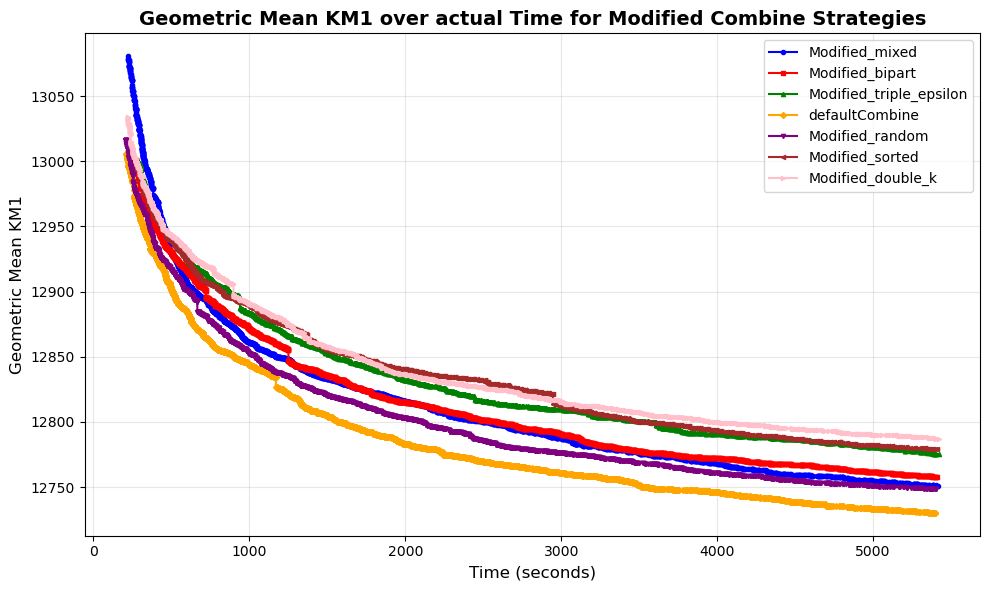

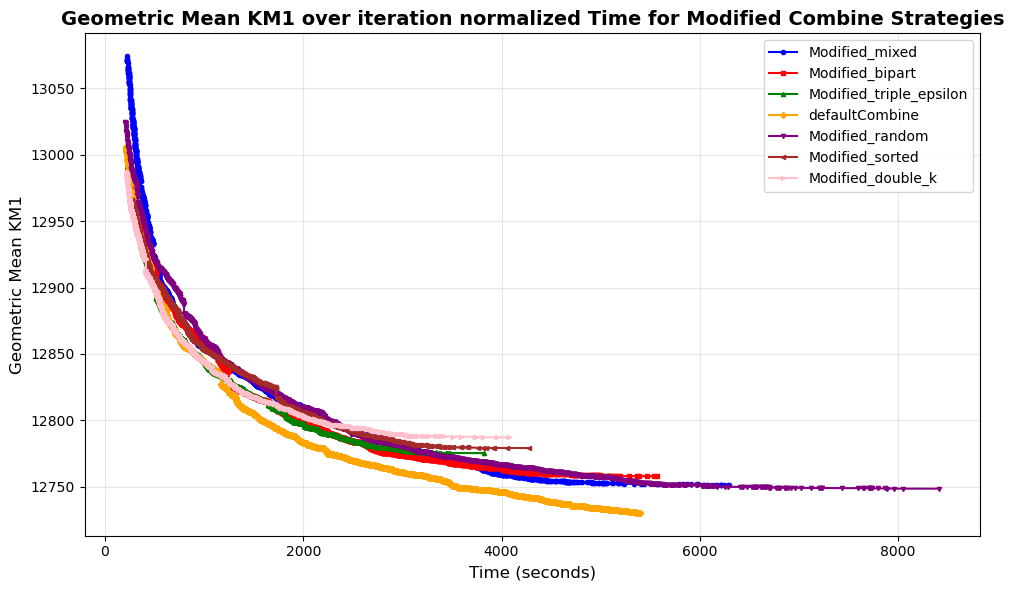

In [2]:
CONFIGS_NAME = "2025-11-25_combined_results"
ALL_CONFIGS_DIR = os.path.expanduser(f"~/Documents/experiment_results/{CONFIGS_NAME}")
RESULTS = "mt_kahypar_evo_results"
DIFF = "evo_diff"
HISTORY = "evo_history"
ITERATION_LOG = "evo_iteration_log"
DEFAULT_POP_SIZE = 10
INSTANCES_TO_EXCLUDE = ["Pd_rhs.mtx.hgr", "wb-edu.mtx.hgr"]
show_full_history = True

modifiedCombines_to_geomeans, save_path = eval_generic_by_name(
    configs_name=CONFIGS_NAME,
    all_configs_root=os.path.expanduser("~/Documents/experiment_results"),
    results_dirname=RESULTS,
    diff_dirname=DIFF,
    history_dirname=HISTORY,
    instances_to_exclude=INSTANCES_TO_EXCLUDE,
    show_full_history=show_full_history)

# Go through all config directories
all_aggregated_iteration_runs = {}
all_aggregated_history_runs = {}
for config_dir in glob.glob(ALL_CONFIGS_DIR + "/*/"):
    iteratiion_log_path = os.path.join(config_dir, ITERATION_LOG)
    history_path = os.path.join(config_dir, HISTORY)
    config_name = os.path.basename(os.path.normpath(config_dir))
    config_name = remove_date_prefix(config_name)
    all_aggregated_iteration_runs[config_name] = aggregate_iterations_runs(iteratiion_log_path, show_full_history=show_full_history, instances_to_exclude=INSTANCES_TO_EXCLUDE)
    all_aggregated_history_runs[config_name] = aggregate_history_runs(history_path, full_history=show_full_history, instances_to_exclude=INSTANCES_TO_EXCLUDE)

# Create geomeans for iterations
all_geomeans_iterations = {}
current_max = 0
for config_name, iteration_runs in all_aggregated_iteration_runs.items():
    max_iterations = max_iterations_per_instance(iteration_runs, multiple_seeds=show_full_history)
    if "default" in config_name:
        baseline_iterations = max_iterations
        break

# Calculate multipliers for each config based on baseline       
for config_name, iteration_runs in all_aggregated_iteration_runs.items():
    max_iterations = max_iterations_per_instance(iteration_runs, multiple_seeds=show_full_history)
    multipliers = get_iteration_multipliers(baseline_max_iterations=baseline_iterations, other_max_iterations=max_iterations)

    adjusted_history_runs = create_multiplier_based_history_runs(all_aggregated_history_runs[config_name], multipliers)
    all_geomeans_iterations[config_name] = create_geomean_over_all_instances(adjusted_history_runs, multiple_seeds=show_full_history)


# Plot all in one plot
labels_for_all = []
for config_name, geomean in modifiedCombines_to_geomeans.items():
    labels_for_all.append(config_name)
plot_time_series(*modifiedCombines_to_geomeans.values(), 
                     title="Geometric Mean KM1 over actual Time for Modified Combine Strategies",
                     labels=labels_for_all,
                     save=True,
                     save_dir=save_path)

labels_for_all = []
for config_name, geomean in all_geomeans_iterations.items():
    labels_for_all.append(config_name)
plot_time_series(*all_geomeans_iterations.values(), 
                     title="Geometric Mean KM1 over iteration normalized Time for Modified Combine Strategies",
                     labels=labels_for_all,
                     save=True,
                     save_dir=save_path)